# Anime Recommendation System with Filtering Methods

**Andreas Nugroho R**<br>
**18 November 2019**

The data is gathered from [My Anime List.](https://www.myanimelist.net 'My Anime List')

In [24]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
anime = pd.read_csv('anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
print(anime.shape)

(12294, 7)


In [5]:
rating = pd.read_csv('rating.csv')
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## User-Based Collaborative Filtering

### Data Cleaning

In [6]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [7]:
rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [8]:
anime['type'] = anime['type'].fillna('NaN')
anime['genre'] = anime['genre'].fillna('NaN')
anime['rating'] = anime['rating'].fillna('NaN')
anime.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [9]:
# create index for the anime's name
anime_index = pd.Series(anime.index, index=anime.name)
anime_index.head()

name
Kimi no Na wa.                      0
Fullmetal Alchemist: Brotherhood    1
Gintama°                            2
Steins;Gate                         3
Gintama&#039;                       4
dtype: int64

In [16]:
joined = anime.merge(rating, how='inner', on='anime_id')
joined.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [17]:
joined = joined[['user_id', 'name', 'rating_y']]

# memory error, so we only use 10000 users
joined = joined[(joined['user_id'] <= 10000)]

pivot = pd.pivot_table(joined, index='user_id', columns='name', values='rating_y')
pivot.head()

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


In [18]:
pivot.shape

(10000, 8337)

In [19]:
# drop all user who never rate any anime
pivot.dropna(axis=0, how='all', inplace=True)
pivot.head()

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


In [20]:
pivot.shape

(10000, 8337)

In [21]:
# center the mean around 0 (centered cosine/Pearson)
pivot_norm = pivot.apply(lambda x: x - np.nanmean(x), axis=1)
pivot_norm.head()

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.263383,NaN,NaN,NaN,NaN,NaN


In [22]:
# fill NaN with 0
pivot_norm.fillna(0, inplace=True)
pivot_norm.head()

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-2.263383,0.0,0.0,0.0,0.0,0.0


### Create Similarity Matrix

In [25]:
# calculate for similar users
# convert into dataframe to make it easier
user_sim_df = pd.DataFrame(cosine_similarity(pivot_norm, pivot_norm), index=pivot_norm.index, columns=pivot_norm.index)
user_sim_df.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.010815,0.003373,0.0,-0.071291,0.0,0.000767,0.061990,0.0,0.214755,...,-0.005408,-0.005213,0.006604,0.000296,-0.003190,-0.143649,-0.006959,-0.074920,-0.081587,0.046268
2,-0.010815,1.000000,0.112274,0.0,0.004048,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,-0.016850,0.000000,0.000000,-0.026056,-0.003331,0.000000,0.000000,0.000000,0.000000
3,0.003373,0.112274,1.000000,0.0,0.056141,0.0,0.109283,0.021432,0.0,0.013094,...,-0.064352,0.030726,0.009860,0.039145,0.028665,0.016128,0.005701,0.048291,0.006040,0.040734
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-0.071291,0.004048,0.056141,0.0,1.000000,0.0,0.061802,0.012980,0.0,-0.058502,...,0.004048,0.015994,0.037352,0.016233,0.080309,0.140691,-0.012827,0.030567,0.023746,-0.003282


In [26]:
def get_similar_user(user_id):
    if user_id not in pivot_norm.index:
        return None, None
    else:
        sim_users = user_sim_df.sort_values(by=user_id, ascending=False).index[1:]
        sim_score = user_sim_df.sort_values(by=user_id, ascending=False).loc[:, user_id].tolist()[1:]
        return sim_users, sim_score

In [27]:
# using the example of user ID no. 3, get similar users to that user
users, score = get_similar_user(3)
for x,y in zip(users[:10], score[:10]):
    print("User {} with similarity of {}".format(x, y))

User 2277 with similarity of 0.5017837487412397
User 4647 with similarity of 0.44718084735091995
User 3225 with similarity of 0.4065669050338233
User 6563 with similarity of 0.3407747640123184
User 1038 with similarity of 0.32848772533578535
User 1406 with similarity of 0.32567421433245575
User 3028 with similarity of 0.3176017336971052
User 934 with similarity of 0.31072300392156893
User 4037 with similarity of 0.31066442336486566
User 9577 with similarity of 0.27885587366117576


### Get Recommendation

In [64]:
def get_recommendation_ucf(user_id, n_anime=10):
    users, scores = get_similar_user(user_id)
    
    # there is no information for this user
    if users is None or score is None:
        return None
    
    # only take 10 nearest users
    user_arr = np.array([x for x in users[:10]])
    sim_arr = np.array([x for x in scores[:10]])
    predicted_rating = np.array([])
    
    for anime_name in pivot_norm.columns:
        filtering = pivot_norm[anime_name].loc[user_arr] != 0.0  
        temp = np.dot(pivot[anime_name].loc[user_arr[filtering]], sim_arr[filtering]) / np.sum(sim_arr[filtering])
        predicted_rating = np.append(predicted_rating, temp)
    
    # don't recommend something that user has already rated
    temp = pd.DataFrame({'predicted':predicted_rating, 'name':pivot_norm.columns})
    filtering = (pivot_norm.loc[user_id] == 0.0)
    temp = temp.loc[filtering.values].sort_values(by='predicted', ascending=False)

    # recommend n_anime anime
    return anime.loc[anime_index.loc[temp.name[:n_anime]]]

In [65]:
get_recommendation_ucf(99)

,anime_id,name,genre,type,episodes,rating,members
192,9617,K-On! Movie,"Comedy, Music, Slice of Life",Movie,1,8.34,115252
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
711,6862,K-On!: Live House!,"Comedy, Music, School, Slice of Life",Special,1,7.88,70787
1193,15775,Saint☆Oniisan,"Comedy, Seinen, Slice of Life",OVA,2,7.64,33668
136,2418,Stranger: Mukou Hadan,"Action, Adventure, Historical, Samurai",Movie,1,8.43,125503
39,12365,Bakuman. 3rd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.71,133620
4983,10491,Higurashi no Naku Koro ni Kira,"Mystery, Parody",OVA,4,6.58,46712
144,1889,Higurashi no Naku Koro ni Kai,"Mystery, Psychological, Supernatural, Thriller",TV,24,8.41,218101
359,4901,Black Lagoon: Roberta&#039;s Blood Trail,"Action, Seinen",OVA,5,8.15,108099
693,9734,K-On!!: Keikaku!,"Comedy, Music, School, Slice of Life",Special,1,7.89,50496


## Content-Based Filtering

In [34]:
df = pd.read_csv("anime.csv")
display(df.head())
display(df.shape)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


(12294, 7)

In [35]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

### Handling Missing Values

In [36]:
# missing rating
df.loc[df['rating'].isnull(), 'rating'] = 0.0
df['rating'].isnull().any()

False

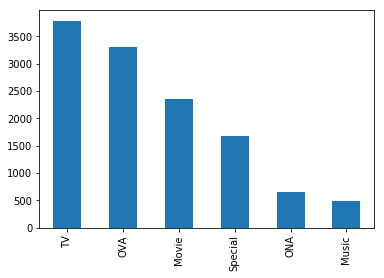

In [37]:
# missing type
df['type'].value_counts().plot.bar()

In [38]:
df.loc[(df['episodes']=="Unknown") & (df['type'].isnull())].head()

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666


Some of the anime have missing type and unknown episodes.

In [39]:
missing = df.loc[(df['episodes']=="Unknown") & (df['type'].isnull())].copy()
missing.shape

(25, 7)

Manually fill the types and episodes for this missing list.

In [40]:
missing.head(25)

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666
10949,33475,Busou Shoujo Machiavellianism,"Action, School, Shounen",NaN,Unknown,0.0,1896
10963,31456,Code:Realize: Sousei no Himegimi,"Adventure, Fantasy, Romance, Shoujo",NaN,Unknown,0.0,4017
10983,34332,Flying Babies,NaN,NaN,Unknown,0.0,22
10988,34280,Gamers!,"Comedy, Romance, School",NaN,Unknown,0.0,1045
10990,34485,Ganko-chan,NaN,NaN,Unknown,0.0,11


In [41]:
df.loc[(df['name'] == "Steins;Gate 0"), 'type'] = 'TV'
df.loc[(df['name'] == "Steins;Gate 0"), 'episodes'] = '23'
df.loc[(df['name'] == "Violet Evergarden"), 'type'] = 'TV'
df.loc[(df['name'] == "Violet Evergarden"), 'episodes'] = '13'
df.loc[(df['name'] == "Code Geass: Fukkatsu no Lelouch"), 'type'] = 'TV'
df.loc[(df['name'] == "Code Geass: Fukkatsu no Lelouch"), 'episodes'] = '25'
df.loc[(df['name'] == "K: Seven Stories"), 'type'] = 'Movie'
df.loc[(df['name'] == "K: Seven Stories"), 'episodes'] = '6'
df.loc[(df['name'] == "Free! (Shinsaku)"), 'type'] = 'TV'
df.loc[(df['name'] == "Free! (Shinsaku)"), 'episodes'] = '12'
df.loc[(df['name'] == "Busou Shoujo Machiavellianism"), 'type'] = 'TV'
df.loc[(df['name'] == "Busou Shoujo Machiavellianism"), 'episodes'] = '12'
df.loc[(df['name'] == "Code:Realize: Sousei no Himegimi"), 'type'] = 'TV'
df.loc[(df['name'] == "Code:Realize: Sousei no Himegimi"), 'episodes'] = '12'
df.loc[(df['name'] == "Gamers!"), 'type'] = 'TV'
df.loc[(df['name'] == "Gamers!"), 'episodes'] = '12'
df.loc[(df['name'] == "Ganko-chan"), 'type'] = 'TV'
df.loc[(df['name'] == "Ganko-chan"), 'episodes'] = '10'
df.loc[(df['name'] == "Ginga Eiyuu Densetsu (2017)"), 'type'] = 'OVA'
df.loc[(df['name'] == "Ginga Eiyuu Densetsu (2017)"), 'episodes'] = '110'
df.loc[(df['name'] == "Grancrest Senki"), 'type'] = 'TV'
df.loc[(df['name'] == "Grancrest Senki"), 'episodes'] = '24'
df.loc[(df['name'] == "IDOLiSH7"), 'type'] = 'TV'
df.loc[(df['name'] == "IDOLiSH7"), 'episodes'] = '17'
df.loc[(df['name'] == "Isekai Shokudou"), 'type'] = 'TV'
df.loc[(df['name'] == "Isekai Shokudou"), 'episodes'] = '12'
df.loc[(df['name'] == "Oushitsu Kyoushi Haine"), 'type'] = 'TV'
df.loc[(df['name'] == "Oushitsu Kyoushi Haine"), 'episodes'] = '12'
df.loc[(df['name'] == "Peace Maker Kurogane (Shinsaku)"), 'type'] = 'TV'
df.loc[(df['name'] == "Peace Maker Kurogane (Shinsaku)"), 'episodes'] = '24'
df.loc[(df['name'] == "Seikaisuru Kado"), 'type'] = 'TV'
df.loc[(df['name'] == "Seikaisuru Kado"), 'episodes'] = '12'
df.loc[(df['name'] == "UQ Holder!"), 'type'] = 'TV'
df.loc[(df['name'] == "UQ Holder!"), 'episodes'] = '12'
df.loc[(df['name'] == "Citrus"), 'type'] = 'TV'
df.loc[(df['name'] == "Citrus"), 'episodes'] = '12'
df.loc[(df['name'] == "Hitorijime My Hero"), 'type'] = 'TV'
df.loc[(df['name'] == "Hitorijime My Hero"), 'episodes'] = '12'
df.isnull().sum()

anime_id     0
name         0
genre       62
type         6
episodes     0
rating       0
members      0
dtype: int64

In [42]:
# drop anime with unknown types
df.dropna(subset=['type'], inplace=True)
df.shape

(12288, 7)

In [43]:
df.isnull().sum()

anime_id     0
name         0
genre       61
type         0
episodes     0
rating       0
members      0
dtype: int64

In [44]:
# fill unknown genre with 'Unknown'
df['genre'].fillna('Unknown', inplace=True)
df.isnull().any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

### Building The Recommender System

In [45]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [46]:
# Calculate weighted rating
m = df.members.quantile(0.75)
C = df.rating.mean()
print(m, C)

9448.5 6.355887858072929


In [47]:
def weighted_rating(df, m, C):
    term = df['members'] / (m + df['members'])
    return df['rating'] * term + (1-term) * C

In [48]:
df['community_rating'] = df.apply(weighted_rating, axis=1, args=(m,C))
df.head()

,anime_id,name,genre,type,episodes,rating,members,community_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,9.234437
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,9.225834
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,9.028960
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.131071
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,8.995145


In [49]:
# Drop some unused columns
df.drop(['anime_id', 'rating', 'members', 'episodes'], axis=1, inplace=True)
df.head()

,name,genre,type,community_rating
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.234437
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.225834
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.028960
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.131071
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,8.995145


In [50]:
# Break down the genre and type
df = pd.concat([df, df['type'].str.get_dummies(), df['genre'].str.get_dummies(sep=',')], axis=1)
df.head()

,name,genre,type,community_rating,Movie,Music,ONA,OVA,Special,TV,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.234437,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.225834,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.028960,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.131071,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,8.995145,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
anime_features = df.loc[:, "Movie":].copy()
anime_features.head()

,Movie,Music,ONA,OVA,Special,TV,Adventure,Cars,Comedy,Dementia,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Calculate Similarity Matrix

In [53]:
cosine_sim = cosine_similarity(anime_features.values, anime_features.values)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31622777],
       [0.        , 1.        , 0.375     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.375     , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.31622777, 0.        , 0.        , ..., 0.5       , 0.5       ,
        1.        ]])

In [54]:
cosine_sim.shape

(12288, 12288)

In [55]:
# Create indexing for each anime name
anime_index = pd.Series(df.index, index=df.name).drop_duplicates()

In [60]:
def get_recommendation_cf(anime_name, similarity=cosine_sim):
    idx = anime_index[anime_name]
    
    # Get the pairwise similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar anime
    sim_scores = sim_scores[0:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar anime
    result = df[['name', 'genre', 'community_rating']].iloc[anime_indices].drop(idx)
    return result

In [73]:
get_recommendation_cf("Dragon Ball Z")

,name,genre,community_rating
515,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.710105
588,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.830726
1930,Dragon Ball Super,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.318395
74,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.539140
1409,Dragon Ball Z Movie 15: Fukkatsu no F,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.326581
3203,Dragon Ball Z: Summer Vacation Special,"Action, Adventure, Comedy, Fantasy, Martial Ar...",6.571273
4275,Dragon Ball Z: Atsumare! Gokuu World,"Action, Adventure, Comedy, Fantasy, Martial Ar...",6.564117
4314,Dragon Ball GT: Goku Gaiden! Yuuki no Akashi w...,"Action, Adventure, Comedy, Fantasy, Martial Ar...",6.661971
5999,Dragon Ball Z Movie 11: Super Senshi Gekiha!! ...,"Action, Adventure, Comedy, Fantasy, Martial Ar...",6.292072
615,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",7.912437


In [62]:
get_recommendation_cf("Kimi no Na wa.")

,name,genre,community_rating
208,Kokoro ga Sakebitagatterunda.,"Drama, Romance, School",8.051436
1494,Harmonie,"Drama, School, Supernatural",7.234142
1959,Air Movie,"Drama, Romance, Supernatural",7.207802
60,Hotarubi no Mori e,"Drama, Romance, Shoujo, Supernatural",8.507055
1199,&quot;Bungaku Shoujo&quot; Movie,"Drama, Mystery, Romance, School",7.391296
2103,Clannad Movie,"Drama, Fantasy, Romance, School",7.263791
5796,Taifuu no Noruda,"Drama, School, Sci-Fi, Supernatural",6.352344
5805,Wind: A Breath of Heart OVA,"Drama, Romance, School, Supernatural",6.354841
6394,Wind: A Breath of Heart (TV),"Drama, Romance, School, Supernatural",6.258412
894,Momo e no Tegami,"Drama, Supernatural",7.443333


In [63]:
get_recommendation_cf("Naruto")

,name,genre,community_rating
615,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",7.912437
175,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",8.298872
206,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.271811
515,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.710105
588,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.830726
1209,Medaka Box Abnormal,"Action, Comedy, Ecchi, Martial Arts, School, S...",7.472471
1930,Dragon Ball Super,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.318395
2615,Medaka Box,"Action, Comedy, Ecchi, Martial Arts, School, S...",7.142463
3038,Tenjou Tenge,"Action, Comedy, Ecchi, Martial Arts, School, S...",7.037725
178,Boku no Hero Academia,"Action, Comedy, School, Shounen, Super Power",8.295029


## Hybrid Recommender System

In [71]:
# create input from content-based filtering to user-based collaborative filtering
user_id = int(input('Enter user ID: '))
get_recommendation_cf(user_id)

Enter user ID: 777


,name,genre,community_rating
1641,Shin Getter Robo,"Action, Adventure, Demons, Horror, Mecha, Sci-...",6.724125
4635,Bubblegum Crash,"Action, Adventure, Mecha, Sci-Fi, Shounen",6.462085
6425,Genocyber,"Action, Horror, Mecha, Psychological, Sci-Fi",6.223154
3438,Kikaider 01 The Animation,"Action, Adventure, Drama, Mecha, Sci-Fi, Shounen",6.453063
3467,Choujikuu Seiki Orguss 02,"Action, Adventure, Mecha, Romance, Sci-Fi, Sho...",6.444135
8373,Choujikuu Seiki Orguss Memorial,"Action, Adventure, Mecha, Romance, Sci-Fi, Sho...",6.356386
1730,"Suisei no Gargantia: Meguru Kouro, Haruka","Action, Adventure, Mecha, Sci-Fi",7.107555
1935,Irregular Hunter X: The Day of Sigma,"Action, Mecha, Sci-Fi, Shounen",6.775476
2729,Shin Getter Robo tai Neo Getter Robo,"Action, Mecha, Sci-Fi, Shounen",6.519417
2826,Uchuu no Kishi Tekkaman Blade OVA: Twin Blood,"Action, Mecha, Sci-Fi, Shounen",6.520494


In [72]:
input_to_ucf = get_recommendation_cf(user_id).head(5)

In [ ]:
def get_recommendation_ucf(user_id, n_anime=10):
    users, scores = get_similar_user(user_id)
    
    # there is no information for this user
    if users is None or score is None:
        return None
    
    # only take 10 nearest users
    user_arr = np.array([x for x in users[:10]])
    sim_arr = np.array([x for x in scores[:10]])
    predicted_rating = np.array([])
    
    for anime_name in pivot_norm.columns:
        filtering = pivot_norm[anime_name].loc[user_arr] != 0.0  
        temp = np.dot(pivot[anime_name].loc[user_arr[filtering]], sim_arr[filtering]) / np.sum(sim_arr[filtering])
        predicted_rating = np.append(predicted_rating, temp)
    
    # don't recommend something that user has already rated
    temp = pd.DataFrame({'predicted':predicted_rating, 'name':pivot_norm.columns})
    filtering = (pivot_norm.loc[user_id] == 0.0)
    temp = temp.loc[filtering.values].sort_values(by='predicted', ascending=False)

    # recommend n_anime anime
    return anime.loc[anime_index.loc[temp.name[:n_anime]]]

In [70]:
get_recommendation_ucf(input_to_ucf)

TypeError: Indexing a Series with DataFrame is not supported, use the appropriate DataFrame column